# ISYE 6740 Project - NBA Players Career Trajectory Prediction
### Author: Daniel Jiang, Nafiz Haider

The National Basketball Association (NBA) is the premier professional basketball association in the world. This sport has produced numerous stars and all time greats. There have been even more players that have excelled in their first, or rookie, NBA seasons. However, we have seen that a more accurate prediction of a player’s trajectory is from their second season.

In [37]:
# load libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import re
import csv
from bs4 import BeautifulSoup

In [3]:
def read_data(year):
    pass

def perform_clustering():
    pass

def plot_clusters():
    pass

"""
combines a player's data from different dataframes into one dataframe
"""
def merge_player_data():
    pass

def PCA():
    pass

In [28]:
# All Current second year players data
second_yrs_pd = pd.read_csv('data/second_yrs_1990-2010.csv', header=1)
# second_yrs_pd = second_yrs_pd.iloc[1:,:]
player_list = second_yrs_pd.iloc[:,1]

In [94]:
def scrape_player_career(player_id):
    """
    given player ID, return player's career averages as pandas data frame
    """
    out_path = 'data/{}.csv'.format(player_id)
    csv_file = open(out_path, 'w')
    csv_writer = csv.writer(csv_file)
    
    features = ['G','GS','MP','FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%',
                'eFG%','FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
    
    csv_writer.writerow(features)
    
    URL = 'https://www.basketball-reference.com/players/a/{}.html'.format(player_id)
    r = requests.get(URL)
    soup = BeautifulSoup(r.text, "html5lib")
    career_per = soup.find(id="per_game").tfoot.contents[0]
    
    # extract desired columns
    G = career_per.contents[5].contents[0]
    GS = career_per.contents[6].contents[0]
    MP = career_per.contents[7].contents[0]
    FG = career_per.contents[8].contents[0]
    FGA = career_per.contents[9].contents[0]
    FG_PCT = career_per.contents[10].contents[0]
    THREE_P = career_per.contents[11].contents[0]
    THREE_PA = career_per.contents[12].contents[0]
    THREE_PCT = career_per.contents[13].contents[0]
    TWO_P = career_per.contents[14].contents[0]
    TWO_PA = career_per.contents[15].contents[0]
    TWO_PCT = career_per.contents[16].contents[0]
    EFG_PCT = career_per.contents[17].contents[0]
    FT = career_per.contents[18].contents[0]
    FTA = career_per.contents[19].contents[0]
    FT_PCT = career_per.contents[20].contents[0]
    ORB = career_per.contents[21].contents[0]
    DRB = career_per.contents[22].contents[0]
    TRB = career_per.contents[23].contents[0]
    AST = career_per.contents[24].contents[0]
    STL = career_per.contents[25].contents[0]
    BLK = career_per.contents[26].contents[0]
    TOV = career_per.contents[27].contents[0]
    PF = career_per.contents[28].contents[0]
    PTS = career_per.contents[29].contents[0]
    print(PTS)
    
    row = [G,GS,MP,FG,FGA,FG_PCT,THREE_P,THREE_PA,THREE_PCT,TWO_P,TWO_PA,TWO_PCT,
            EFG_PCT,FT,FTA,FT_PCT,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS]
    csv_writer.writerow(row)
    ncolumns = len(features)
    
    return 0

In [95]:
scrape_player_career('anthoca01')

23.6


0

In [32]:
# All Current second year players data
second_years_current_pd = pd.read_csv('data/Second_Years_2019-2020.csv')
second_years_current = second_years_current_pd.to_numpy()[1:,7:].astype(float)
second_years_current = np.nan_to_num(second_years_current)

# Dummy dataset of second year players from 2004-2005
# This needs to be career data of all players from 1990-2011 that started their second years
second_years_lebron_pd= pd.read_csv('data/Second_Years_2004-2005.csv')
second_years_lebron = second_years_lebron_pd.to_numpy()[1:,7:].astype(float)
second_years_lebron = np.nan_to_num(second_years_lebron)

In [33]:
# grab data of career and second seasons for each player from 1990 to 2010 (who is sophomore that season)
# store in pandas: one table for career averages and one table for second season averages

# All player averages in their second season 1990-2011
#https://www.basketball-reference.com/play-index/psl_finder.cgi?request=1&match=single&type=per_game&per_minute_base=36&per_poss_base=100&season_start=2&season_end=2&lg_id=NBA&age_min=0&age_max=99&is_playoffs=N&height_min=0&height_max=99&year_min=1991&year_max=2011&birth_country_is=Y&as_comp=gt&as_val=0&pos_is_g=Y&pos_is_gf=Y&pos_is_f=Y&pos_is_fg=Y&pos_is_fc=Y&pos_is_c=Y&pos_is_cf=Y&order_by=season&order_by_asc=Y

#Second season averages for 2019-2020 players
#https://www.basketball-reference.com/play-index/psl_finder.cgi?request=1&match=single&type=per_game&per_minute_base=36&per_poss_base=100&season_start=2&season_end=2&lg_id=NBA&age_min=0&age_max=99&is_playoffs=N&height_min=0&height_max=99&year_min=2020&year_max=2020&birth_country_is=Y&as_comp=gt&as_val=0&pos_is_g=Y&pos_is_gf=Y&pos_is_f=Y&pos_is_fg=Y&pos_is_fc=Y&pos_is_c=Y&pos_is_cf=Y&order_by=season&order_by_asc=Y

#https://www.basketball-reference.com/play-index/psl_finder.cgi?request=1&match=single&type=per_game&per_minute_base=36&per_poss_base=100&season_start=2&season_end=2&lg_id=NBA&age_min=0&age_max=99&is_playoffs=N&height_min=0&height_max=99&year_min=2005&year_max=2005&birth_country_is=Y&as_comp=gt&as_val=0&pos_is_g=Y&pos_is_gf=Y&pos_is_f=Y&pos_is_fg=Y&pos_is_fc=Y&pos_is_c=Y&pos_is_cf=Y&order_by=season&order_by_asc=Y


## Missing dataset to compare career data with corresponding second year data

# PCA Dimension reduction
pca = PCA(n_components=2)
pca.fit(second_years_lebron)
#variance = pca.explained_variance_ratio_
reduced_representation_career_data = pca.transform(second_years_lebron)
print(reduced_representation_career_data[32,])

# kmedoids clustering of career stats
kmedoids = KMedoids(n_clusters=6, random_state=0).fit(reduced_representation_career_data)
kmedoids.labels_ #cluster labels
print(kmedoids.labels_ [32,])
career_centers = kmedoids.cluster_centers_ #cluster centers
print(career_centers)

[70.0371436 15.1942194]
3
[[-12.32041421   4.61467644]
 [  1.15760571   1.15284367]
 [-14.08882239  -1.7221756 ]
 [ 61.21193554  -0.38141243]
 [-20.06190762   1.52231269]
 [-23.48531451  -3.81442727]]


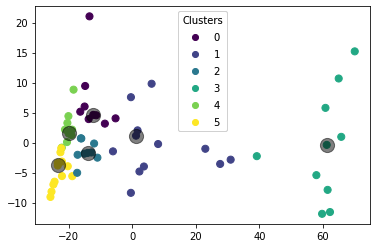

array([0, 5, 2, 1, 1, 0, 0, 2, 1, 1, 3, 2, 3, 1, 1, 2, 0, 3, 2, 2, 2, 5,
       0, 1, 3, 2, 0, 5, 1, 3, 0, 3, 2, 2, 0, 1, 3, 1, 0, 3, 5, 5, 2, 0,
       2, 5, 5, 2, 1, 2, 1, 2, 1, 2, 1, 2, 3, 2, 1, 3, 1, 0, 5, 0, 2, 1,
       0, 5, 5, 0, 0, 2, 0, 2, 2, 1, 0, 3])

In [34]:
# Graph clusters
y_kmedoids = kmedoids.predict(reduced_representation_career_data)
fig, ax = plt.subplots()
scatter = ax.scatter(reduced_representation_career_data[:, 0], reduced_representation_career_data[:, 1], c=y_kmedoids, s=50, cmap='viridis')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Clusters")
ax.add_artist(legend1)
plt.scatter(career_centers[:, 0], career_centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

# Assign "true" cluster assignment after based on things we can look up.
# i.e. % of games started, all star appearances, all nba appearances, etc.
# Find accuracy of results
#actual_labels = 
#false_classification_rate = np.count_nonzero(kmedoids.labels_==actual_labels)/len(kmedoids.labels_)

# Map career data to second year data by row number
# Find second year "averages" for each stat of each cluster

# Fit current crop of second year players to clusters... 
# this will need to change once we implement finding second year averages per cluster
# probably euclidean distance measurements with the averages from above
pca.fit(second_years_current)
#variance = pca.explained_variance_ratio_
reduced_representation_second_years_current = pca.transform(second_years_current)
kmedoids.predict(reduced_representation_second_years_current)
